In [39]:
from pathlib import Path
import random, json
import numpy as np
import torch, os
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms, datasets
from PIL import Image
import timm
from tqdm import tqdm
from typing import List, Tuple, Dict, Optional
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report

Create Config metrics for easier variable changing later down the line

In [23]:
DATA_ROOT = Path("data")   # <-- set path
TRAIN_DIR, TEST_DIR = DATA_ROOT/"train", DATA_ROOT/"test"
MODEL_DIR = Path("models_ultrasound"); MODEL_DIR.mkdir(parents=True, exist_ok=True)

BACKBONE = "efficientnet_b0"
IMG_SIZE, BATCH_SIZE = 224, 12
NUM_EPOCHS, FREEZE_EPOCHS = 30, 5
LR_HEAD, LR_BACKBONE, WEIGHT_DECAY = 1e-3, 1e-4, 1e-5
PATIENCE_ES, VAL_SPLIT, RANDOM_SEED = 6, 0.15, 42
POS_LABEL_IDX, NUM_WORKERS = 0, 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = True

In [24]:
#for reproduction purposes set all variable random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed()


Some files are bad (unfinished downloads / corrupted) we need to remove them beforehand

In [25]:
#most of this is chat lmao
from pathlib import Path
from PIL import Image, ImageFile
import shutil, numpy as np

# Optional OpenCV fallback (more permissive decoder)
try:
    import cv2
    _HAS_CV2 = True
except Exception:
    _HAS_CV2 = False

ImageFile.LOAD_TRUNCATED_IMAGES = True

TEST_DIR = Path("data/test")
QDIR = TEST_DIR / "_quarantine"
QDIR.mkdir(exist_ok=True)

VALID_EXT = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

def verify_with_pillow(p: Path) -> bool:
    try:
        with Image.open(p) as im:
            im.verify()
        return True
    except Exception:
        return False

def try_repair(p: Path) -> bool:
    # 1) Pillow re-encode
    try:
        with Image.open(p) as im:
            im = im.convert("RGB")
            tmp = p.with_suffix(".png")
            im.save(tmp, "PNG")
        shutil.move(str(p), str(QDIR / p.name))  # move original away
        tmp.rename(p.with_suffix(".png"))        # keep repaired PNG in place (new name)
        return True
    except Exception:
        pass
    # 2) OpenCV fallback
    if _HAS_CV2:
        try:
            data = np.fromfile(str(p), dtype=np.uint8)
            img = cv2.imdecode(data, cv2.IMREAD_COLOR)
            if img is not None:
                tmp = p.with_suffix(".png")
                cv2.imwrite(str(tmp), img)
                shutil.move(str(p), str(QDIR / p.name))
                tmp.rename(p.with_suffix(".png"))
                return True
        except Exception:
            pass
    return False

bad, fixed = [], []

for p in TEST_DIR.rglob("*"):
    if not p.is_file():
        continue
    if p.suffix.lower() not in VALID_EXT:
        # Non-image files: quarantine
        shutil.move(str(p), str(QDIR / p.name))
        bad.append(str(p))
        continue

    if verify_with_pillow(p):
        continue

    # Try to repair; if not, quarantine
    if try_repair(p):
        fixed.append(str(p))
    else:
        shutil.move(str(p), str(QDIR / p.name))
        bad.append(str(p))

print(f"Fixed (re-encoded): {len(fixed)}")
print(f"Quarantined:        {len(bad)}")



Fixed (re-encoded): 0
Quarantined:        4


In [34]:
import shutil
shutil.rmtree("data/test/_quarantine", ignore_errors=True)
#delete quarantined files for ease

Data transformations, to further augment the data and be better prepared for actual traning and generalization towards messy irl data

In [26]:
#since expected input are grayscale (ultrasounds) reproduce it into RGB channels so it can work on pretrained models
class Ensure3Channel:
    def __call__(self, img: Image.Image) -> Image.Image:
        return img.convert("RGB")

In [27]:
#necessary transforms for more generalized to prevent overfitting and be better suited to tackle real world input
#actual values is very small so it should still be similar to original image
train_tf = transforms.Compose([
    Ensure3Channel(),
    #randomly crops parts of the images
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.80, 1.0)),
    #applies a small rotation
    transforms.RandomAffine(degrees=10, translate=(0.05,0.05), shear=5),
    #flips image left to right 50% of the time
    transforms.RandomHorizontalFlip(0.5),
    #adds a little color jitter
    transforms.ColorJitter(brightness=0.10, contrast=0.10),
    #adds a slight blur to simulate low res scans
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1,1.0)),
    transforms.ToTensor(),
    #normalizes the pixels for the expected ImageNet Model
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]), 
])

val_tf = transforms.Compose([
    Ensure3Channel(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

Create the data loaders 

In [35]:
def build_dataloaders(train_dir, test_dir):
    #really convenient for subfolder since it expects already that sub dirs are the classes.
    train_full = datasets.ImageFolder(str(train_dir),transform = train_tf)
    class_names = train_full.classes

    #get total length of dataset
    n = len(train_full)
    #get indices and shuffle the images around
    idx = list(range(n)); random.shuffle(idx)
    #create size of val via split
    val_n = int(n * VAL_SPLIT)
    #slice the respective train val splits
    val_idx, tr_idx = idx[:val_n], idx[val_n:]

    #generate subsets for each
    train_subset = Subset(train_full, tr_idx)
    #create the imagefolder with the transform beforehand for val
    train_val = datasets.ImageFolder(str(train_dir), transform=val_tf)
    val_subset = Subset(train_val, val_idx)

    tr_labels = [train_full.samples[i][1] for i in tr_idx]
    class_counts = {class_names[i]: tr_labels.count(i) for i in range(len(class_names))}

    #from looking at the data there seems to be a ~7:11 ratio for infected vs non, use a sampler to remedy the imbalance
    sampler = None
    if all(c > 0 for c in class_counts.values()):
        weights = np.array([1.0 / class_counts[class_names[y]] for y in tr_labels], dtype=np.float32)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=(sampler is None),
                              sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)
    test_ds = datasets.ImageFolder(str(test_dir), transform=val_tf)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=True)
    
    return train_loader, val_loader, test_loader, class_names, class_counts

train_loader, val_loader, test_loader, class_names, class_counts = build_dataloaders(TRAIN_DIR, TEST_DIR)
print("Classes:", class_names, "Train counts:", class_counts)

Classes: ['infected', 'notinfected'] Train counts: {'infected': 662, 'notinfected': 974}


The model we are using is the EfficientNetb0, lightest one in the EfficientNet fam, can upgarde if computing power allows (though it might be overkill).

In [29]:
def create_model(name = BACKBONE, pretrained = True):
    return timm.create_model(name, pretrained = pretrained, num_classes = 1)

#move model to device
model = create_model().to(DEVICE)
print(f"Model {BACKBONE} created on {DEVICE}")

Model efficientnet_b0 created on cuda


In [30]:
#since there is a minor class imbalance, we need to punish the model for miscalssifying infected sets
def pos_weight_from_counts(counts):
    vals = list(counts.values())
    n_pos, n_neg = max(1, vals[POS_LABEL_IDX]), max(1, vals[1 - POS_LABEL_IDX])
    return torch.tensor([n_neg / n_pos], dtype=torch.float32, device=DEVICE)

#define the func to train over one epoch (so we can call it in fit)
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0
    preds = []
    targs = []

    for imgs, y in loader:
        imgs, y = imgs.to(DEVICE),  y.float().unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()
        #create a context object to use both for forward and backward prop
        ctx = torch.cuda.amp.autocast if (USE_AMP and torch.cuda.is_available()) else torch.cpu.amp.autocast

        with ctx():
            logits = model(imgs)
            loss = criterion(logits, y)

        if scaler: 
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()*imgs.size(0)
        preds.append(torch.sigmoid(logits).detach().cpu().numpy().ravel())
        targs.append(y.cpu().numpy().ravel())
 
    return total_loss/len(loader.dataset), roc_auc_score(np.concatenate(targs), np.concatenate(preds))

#disable torch gradient
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval(); total_loss=0; preds=[]; targs=[]
    for imgs,y in loader:
        imgs, y = imgs.to(DEVICE), y.float().unsqueeze(1).to(DEVICE)
        logits = model(imgs); loss = criterion(logits,y)
        total_loss += loss.item()*imgs.size(0)
        preds.append(torch.sigmoid(logits).cpu().numpy().ravel())
        targs.append(y.cpu().numpy().ravel())
    y_true, y_pred = np.concatenate(targs), np.concatenate(preds)
    return (total_loss/len(loader.dataset),
            roc_auc_score(y_true,y_pred),
            average_precision_score(y_true,y_pred),
            y_true, y_pred)

In [31]:
def fit(train_loader, val_loader, test_loader, class_counts):
    model = create_model(BACKBONE).to(DEVICE)

    # freeze backbone first
    if FREEZE_EPOCHS > 0:
        for n,p in model.named_parameters(): p.requires_grad=False
        for n,p in model.named_parameters():
            if any(k in n for k in ("head","fc","classifier","pre_logits")): p.requires_grad=True

    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad],
                                  lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_from_counts(class_counts))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", patience=3)
    scaler = torch.cuda.amp.GradScaler(enabled = USE_AMP and torch.cuda.is_available())

    best_auc, patience = -np.inf, 0
    for epoch in range(1, NUM_EPOCHS+1):
        print(f"Starting epoch {epoch}…", flush=True)
        if epoch == FREEZE_EPOCHS+1: # unfreeze
            for p in model.parameters(): p.requires_grad=True
            optimizer = torch.optim.AdamW(model.parameters(),
                                          lr=LR_BACKBONE, weight_decay=WEIGHT_DECAY)
        tr_loss,tr_auc = train_one_epoch(model,train_loader,optimizer,criterion,scaler)
        va_loss,va_auc,va_ap,_,_ = evaluate(model,val_loader,criterion)
        scheduler.step(va_auc)
        print(f"Epoch {epoch} | Train AUC {tr_auc:.3f} | Val AUC {va_auc:.3f} AP {va_ap:.3f}")
        if va_auc>best_auc: best_auc=va_auc; patience=0; torch.save(model.state_dict(), MODEL_DIR/"best.pth")
        else: patience+=1; 
        if patience>=PATIENCE_ES: print("Early stopping."); break
    return model

model = fit(train_loader,val_loader,test_loader,class_counts)


Starting epoch 1…


C:\Users\Jomar\AppData\Local\Temp\ipykernel_33764\3252578174.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled = USE_AMP and torch.cuda.is_available())
C:\Users\Jomar\AppData\Local\Temp\ipykernel_33764\1738212916.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Epoch 1 | Train AUC 0.995 | Val AUC 1.000 AP 1.000
Starting epoch 2…


C:\Users\Jomar\AppData\Local\Temp\ipykernel_33764\1738212916.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Epoch 2 | Train AUC 0.997 | Val AUC 1.000 AP 1.000
Starting epoch 3…


C:\Users\Jomar\AppData\Local\Temp\ipykernel_33764\1738212916.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Epoch 3 | Train AUC 1.000 | Val AUC 1.000 AP 1.000
Starting epoch 4…


C:\Users\Jomar\AppData\Local\Temp\ipykernel_33764\1738212916.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Epoch 4 | Train AUC 0.997 | Val AUC 1.000 AP 1.000
Starting epoch 5…


C:\Users\Jomar\AppData\Local\Temp\ipykernel_33764\1738212916.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Epoch 5 | Train AUC 0.997 | Val AUC 1.000 AP 1.000
Starting epoch 6…


C:\Users\Jomar\AppData\Local\Temp\ipykernel_33764\1738212916.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Epoch 6 | Train AUC 0.997 | Val AUC 1.000 AP 1.000
Starting epoch 7…


C:\Users\Jomar\AppData\Local\Temp\ipykernel_33764\1738212916.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Epoch 7 | Train AUC 0.996 | Val AUC 1.000 AP 1.000
Early stopping.


Test AUC=1.000, AP=1.000


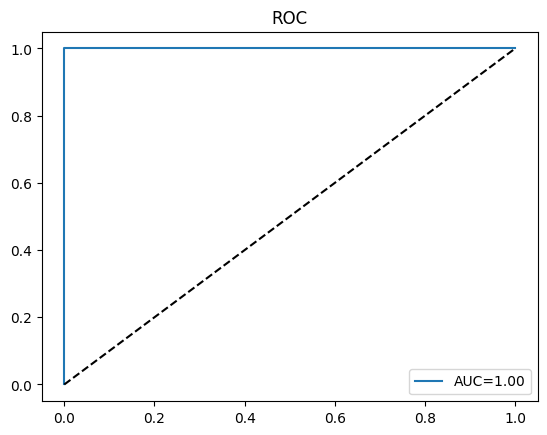

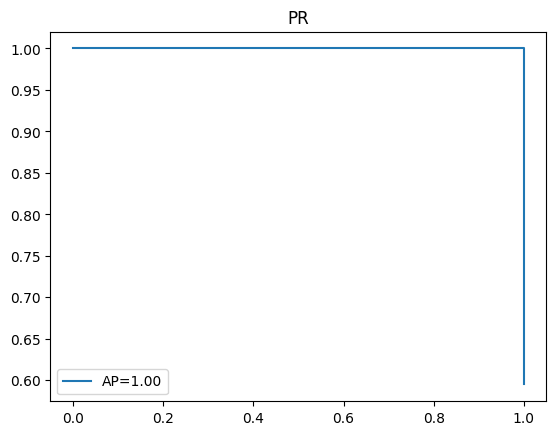

Confusion matrix:
 [[ 772    5]
 [   0 1141]]
Classification report:
               precision    recall  f1-score   support

    infected       1.00      0.99      1.00       777
 notinfected       1.00      1.00      1.00      1141

    accuracy                           1.00      1918
   macro avg       1.00      1.00      1.00      1918
weighted avg       1.00      1.00      1.00      1918



In [37]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(MODEL_DIR/"best.pth", map_location=DEVICE))
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_from_counts(class_counts))

test_loss,test_auc,test_ap,y_true,y_pred = evaluate(model,test_loader,criterion)
print(f"Test AUC={test_auc:.3f}, AP={test_ap:.3f}")

# Plots
fpr,tpr,_ = roc_curve(y_true,y_pred)
prec,rec,_ = precision_recall_curve(y_true,y_pred)

plt.plot(fpr,tpr,label=f"AUC={test_auc:.2f}"); plt.plot([0,1],[0,1],'k--'); plt.title("ROC"); plt.legend(); plt.show()
plt.plot(rec,prec,label=f"AP={test_ap:.2f}"); plt.title("PR"); plt.legend(); plt.show()

pred_bin=(y_pred>=0.5).astype(int)
cm=confusion_matrix(y_true,pred_bin)
print("Confusion matrix:\n",cm)
print("Classification report:\n",classification_report(y_true,pred_bin,target_names=class_names))


ok so its hilariously accurate which is strange, even on test!

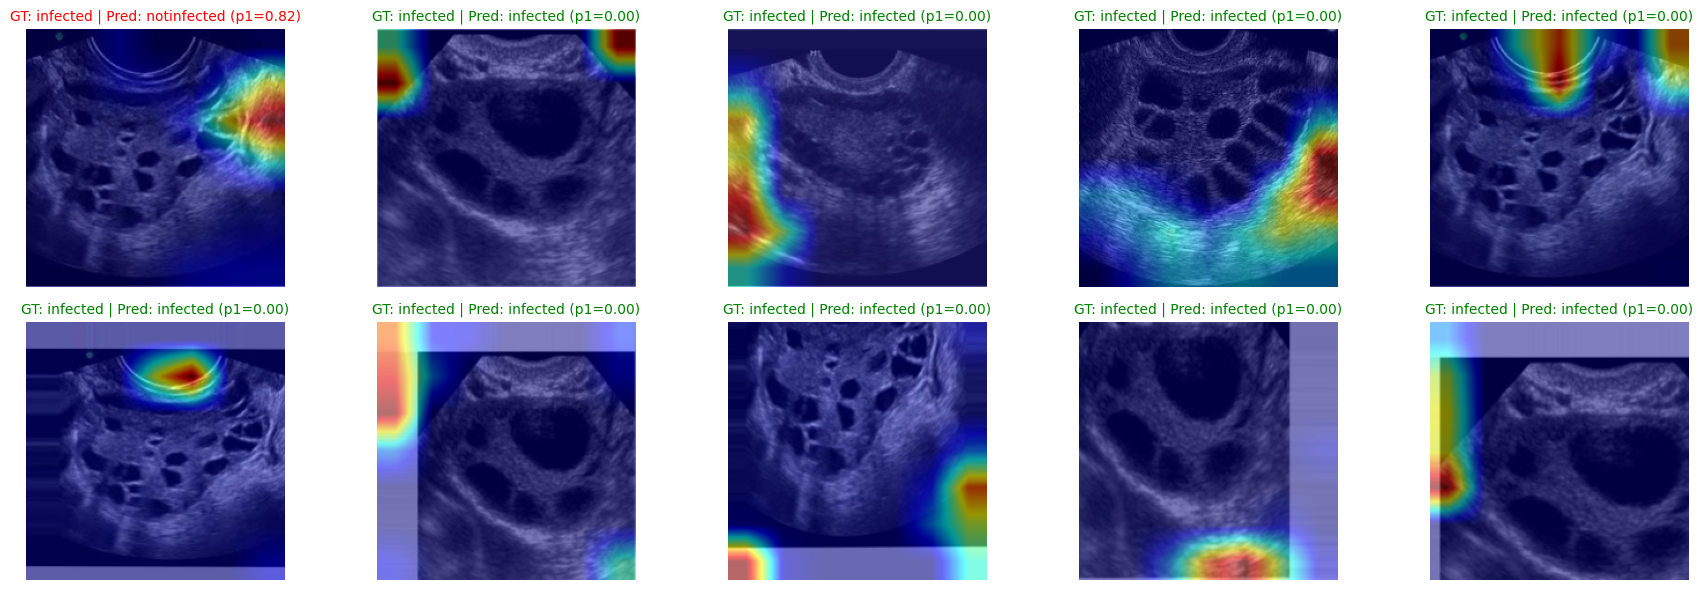

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
model.eval()

# Make sure params can participate in autograd for CAM
for p in model.parameters():
    p.requires_grad = True

# Find last Conv2d
target_layer = None
for n, m in reversed(list(model.named_modules())):
    if isinstance(m, nn.Conv2d):
        target_layer = m
        break
assert target_layer is not None, "No Conv2d layer found."

cam = GradCAM(model=model, target_layers=[target_layer])

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def denorm(img_tensor):
    x = img_tensor.detach().cpu().permute(1, 2, 0).numpy()
    x = (x * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1)
    return x

def prob_from_logits(logits):
    return torch.sigmoid(logits).item()

# ---- Collect 10 examples with Grad-CAM ----
imgs_vis, titles = [], []
n_needed, count = 10, 0

with torch.enable_grad():
    for imgs, labels in test_loader:
        bs = imgs.size(0)
        for b in range(bs):
            if count >= n_needed:
                break

            img = imgs[b].unsqueeze(0).to(DEVICE)      # 1xCxhxw
            img.requires_grad_(True)                   # <-- helps ensure a graph exists

            # forward pass (no no_grad!)
            logits = model(img)                        # 1x1
            p1 = prob_from_logits(logits)
            pred_idx = int(p1 >= 0.5)
            true_idx = int(labels[b].item())

            # Grad-CAM
            grayscale_cam = cam(input_tensor=img)[0]   # HxW, [0,1]
            vis_img = denorm(imgs[b])
            overlay = show_cam_on_image(vis_img, grayscale_cam, use_rgb=True)

            pred_name = class_names[pred_idx]
            true_name = class_names[true_idx]
            title = f"GT: {true_name} | Pred: {pred_name} (p1={p1:.2f})"

            imgs_vis.append(overlay)
            titles.append((title, pred_idx == true_idx))
            count += 1
        if count >= n_needed:
            break

# Plot 10
cols = 5
rows = (n_needed + cols - 1) // cols
plt.figure(figsize=(3.6*cols, 3*rows))
for i in range(n_needed):
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(imgs_vis[i]); ax.axis("off")
    title, ok = titles[i]
    ax.set_title(title, color=("green" if ok else "red"), fontsize=10)
plt.tight_layout(); plt.show()


